# Projet IA : voyageur de commerce
Marie Magny
Mickael Nabet
Maxime Boyer

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import sys

In [2]:
def generate_graph(nbr_sommets=5, max_poids=10):
    graphe = nx.complete_graph(nbr_sommets)
    nx.set_edge_attributes(graphe, {e: {'weight': randint(1, max_poids)} for e in graphe.edges})
    return graphe

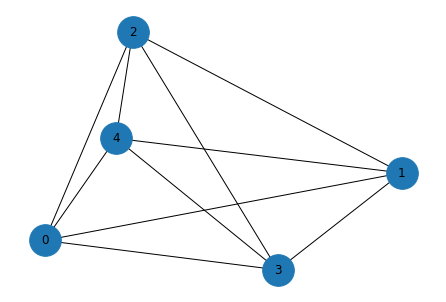

In [3]:
#visualisation
graphe = generate_graph()
nx.draw(graphe, with_labels=True, node_size=1000)
plt.show()

In [4]:
for t in graphe.edges(data=True):
    print(t)

(0, 1, {'weight': 5})
(0, 2, {'weight': 3})
(0, 3, {'weight': 9})
(0, 4, {'weight': 5})
(1, 2, {'weight': 3})
(1, 3, {'weight': 9})
(1, 4, {'weight': 4})
(2, 3, {'weight': 1})
(2, 4, {'weight': 9})
(3, 4, {'weight': 7})


In [5]:
from algorithmx.networkx import add_graph
from algorithmx import jupyter_canvas

canvas = jupyter_canvas()
add_graph(canvas, graphe)

JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}}}}', '{"attrs": {"edge…

https://algrx.github.io/docs/python/examples/networkx-tutorial.html

## A*

Dans un etat, il faut indiquer la ville actuelle ainsi que les autres villes où on est déjà passé
Il faut indiquer tous ces trucs (définir l'etat, les actions possibles, les résultats d'une action dans un état, quel est la condition de fin) pour avoir une bonne note

Spanning tree = heuristique avec sommets restants + sommet actuel + sommet départ

=> but est de choisir la bonne ville pour après dans A*

In [6]:
import sys

class AStar:
    def __init__(self, G):
        self.graphe = G
    
    def actions(self):
        return list(self.frontier.keys())
        
    def result(self, action):
        for l in list(graphe.edges(self.node, data=True)):
            if (l[1] == action):
                self.frontier[action] = self.g_n + l[2]['weight'] + self.result_mst(action)
                break

    def result_mst(self, action):
        mst_graph = nx.Graph()
        mst_graph.add_node(action)
        unexplored = list(self.frontier.keys())
        for j in range(len(self.frontier) - 1):
            mini = sys.maxsize
            i = -1
            for k in list(mst_graph.nodes()):
                for l in list(self.graphe.edges(k, data=True)):
                    if(l[2]["weight"] < mini and l[0] == k and l[1] not in list(mst_graph.nodes()) and l[1] in unexplored):
                        mini = l[2]["weight"]
                        i = l[1]
                    elif(l[2]["weight"] < mini and l[1] == k and l[0] not in list(mst_graph.nodes()) and l[0] in unexplored):
                        mini = l[2]["weight"]
                        i = l[0]
            unexplored.remove(i)
            mst_graph.add_weighted_edges_from([(0, i, mini)])
        total_weight = 0
        for e in list(mst_graph.edges(data=True)):
            total_weight += e[2]["weight"]
        return total_weight
    
    def initiate_frontier(self):
        self.frontier = {list(graphe.edges(self.node))[i][1]: list(graphe.edges(self.node, data=True))[i][2]['weight'] for i in range(graphe.number_of_nodes()-1)}
    
    def my_pop(self):
        mini = sys.maxsize
        i = -1
        for f in self.frontier.items():
            if f[1] < mini:
                mini = f[1]
                i = f[0]
        self.frontier.pop(i)
        for j in range(len(graphe.edges(self.node))):
            if(list(graphe.edges(self.node, data=True))[j][1] == i):
                self.g_n += list(graphe.edges(0, data=True))[j][2]['weight']
                break
        return i
    
    def solve(self):
        self.node = list(self.graphe.nodes)[0]
        self.initiate_frontier()
        self.explored = [self.node]
        self.g_n = 0
        for action in self.actions():
            self.result(action)
        while(len(self.frontier) > 0):
            self.node = self.my_pop()
            self.explored.append(self.node)
            for action in self.actions():
                self.result(action)
        self.explored.append(self.explored[0])
        self.g_n = nx.path_weight(self.graphe, self.explored, weight="weight")
        print("Le meilleur chemin avec l'algorithme A* est " + str(self.explored) + " ce chemin a une distance totale de " + str(self.g_n))

In [7]:
a_star = AStar(graphe)
a_star.solve()

Le meilleur chemin avec l'algorithme A* est [0, 2, 3, 4, 1, 0] ce chemin a une distance totale de 20


Nous avons trouvé une fonction dans networkx qui génère le minimum spanning tree étant donné un graphe. Elle nous a permis de vérifier que notre propre code pour générer cet arbre donnait le même résultat sur plusieurs instances différentes. Ci-dessous, un exemple de comment l'utiliser sur le graphe de départ.

In [8]:
mst_graph = nx.minimum_spanning_tree(graphe, weight='weight', algorithm='prim')

canvas = jupyter_canvas()
add_graph(canvas, mst_graph)

JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}}}}', '{"attrs": {"edge…

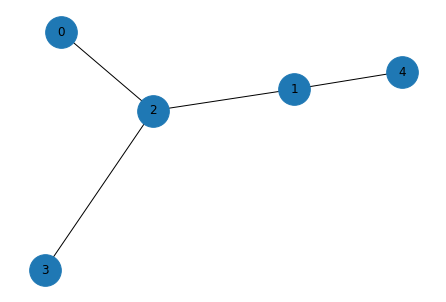

In [9]:
nx.draw(mst_graph, with_labels=True, node_size=1000)
plt.show()

## Recherche locale : genetic algorithm

In [10]:
import numpy as np  

#definir le score de chaque chemin
def fitness(chemin):
    score = 0
    for i in range(len(chemin)-1):
        score += graphe[chemin[i]][chemin[i+1]]['weight']
    score += graphe[chemin[len(chemin)-1]][chemin[0]]['weight']
    return score 

#choix des reproducteurs : on prend ceux qui ont le meilleur score
#on prend 1/3 de la population pour la reproduction
def selection(pop):
    selec_pop = []
    scores = []
    for i in range(len(pop)):
        data = []
        data.append(i)
        data.append(fitness(pop[i]))
        scores.append(data)
    scores_tries = sorted(scores, key=lambda item:(item [1]))
    for i in range(round(len(pop)/3)):
        selec_pop.append(pop[scores_tries[i][0]])
    return selec_pop

#on prend au hasard un individu dans les sélectionnés pour être reproducteurs
def random_selec(pop):
    i = randint(0, len(pop)-1)
    return pop[i]

#on prend les caracteristiques du pere jusqu'au point de croisement ici (sommet/3)
def reproduce(pere, mere, graphe):
    point_crois = round(len(graphe.nodes)/3)
    child = []
    sommets = np.arange(len(graphe.nodes)) 
    for i in range(point_crois):
        child.append(pere[i])
        sommets = np.setdiff1d(sommets, pere[i])
    for i in range(point_crois, len(mere)):
        if(mere[i] in sommets):
            child.append(mere[i])
            sommets = np.setdiff1d(sommets, mere[i])
        else :
            s = sommets[randint(0, len(sommets)-1)]
            child.append(s)
            sommets = np.setdiff1d(sommets, s)
    return child

#on applique la mutation on inversant 2 sommets
def mutate(individu):
    i = randint(0, len(individu)-1)
    temp = individu[i]
    if(i+1==len(individu)):
        individu[i] = individu[0]
        individu[0] = temp
    else: 
        individu[i] = individu[i+1]
        individu[i+1] = temp
    return individu 

#size of the population : nbr sommet * nbr arretes
size_pop = len(graphe.nodes)*len(graphe.edges)
population = []

#generation de la population initiale  
for i in range(size_pop):
    sommets = np.arange(len(graphe.nodes)) 
    np.random.shuffle(sommets)
    chemin = sommets.tolist()
    population.append(chemin)

#evolution de la population
iterations = 0
while(iterations < 10):
    new_population = []
    selec_pop = selection(population)
    for i in range(size_pop):
        pere = random_selec(selec_pop)
        mere = random_selec(selec_pop)
        child = reproduce(pere, mere, graphe)
        proba_mutation = randint(1, 100)
        if(proba_mutation<10):
            child = mutate(child)
        new_population.append(child)
    population = new_population
    iterations += 1

#on prend le meilleur individu
meilleure_pop = selection(population)
#on sélectionne celui qui est en haut du classement 
print(meilleure_pop[0])

[2, 3, 4, 1, 0]
